# Google Colab-specific Setup

In [1]:
!pip install pyswarms==1.1.0

     |████████████████████████████████| 102kB 5.6MB/s 


In [0]:
import gdown
from zipfile import ZipFile
gdown.download('https://drive.google.com/uc?export=download&id=11C8lWqT1Bqva_2NYkoGMqvX5ZF5SVJ4k', 'sls_data.zip', quiet=True)

with ZipFile('sls_data.zip', 'r') as zipObj:
   zipObj.extractall()

# Setup and Configuration

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyswarms as ps
import random

from pathlib import Path

from scipy.optimize import differential_evolution

from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [0]:
#configurations
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [0]:
basepath = Path('.')
raw = pd.read_csv(basepath/'diet_data.csv')

In [7]:
raw.head()

,Date,Stone,Pounds,Ounces,weight_oz,calories,cals_per_oz,five_donuts,walk,run,wine,prot,weight,change
0,7/30/2018,12.0,2.0,6.0,2726.0,1950.0,0.72,1.0,1.0,0.0,0.0,0.0,0.0,-30.0
1,7/31/2018,12.0,0.0,8.0,2696.0,2600.0,0.96,1.0,0.0,0.0,0.0,0.0,0.0,8.0
2,8/1/2018,12.0,1.0,0.0,2704.0,2500.0,0.92,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,8/2/2018,12.0,1.0,0.0,2704.0,1850.0,0.68,1.0,1.0,0.0,1.0,0.0,0.0,-40.0
4,8/3/2018,11.0,12.0,8.0,2664.0,2900.0,1.09,1.0,1.0,0.0,0.0,0.0,0.0,14.0


In [0]:
non_features = ['Stone', 'Pounds', 'Ounces', 'weight_oz', 
                'cals_per_oz', 'five_donuts', 'wine', 'prot', 
                'weight', 'change', 'Date']

In [0]:
def preprocess_data(raw):
    data = raw.dropna()
    X = data.drop(columns=non_features)
    y = data['change']
    exercises = X.columns.tolist()[1:]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,
                                                    test_size=0.2, shuffle=False)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test, exercises, scaler

In [0]:
X_train, X_test, y_train, y_test, exercises, scaler = preprocess_data(raw)

# Linear Regression Baseline Model

In [0]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [12]:
print(f'MSE on validation set: {mean_squared_error(y_test, y_pred)}')

MSE on validation set: 279.388891604964


# PSO-tuned Neural Network Model

In [0]:
def calc_nn_params(n_inputs, n_hidden, n_classes):
    i_weights = n_inputs*n_hidden
    i_bias = n_hidden
    h_weights = n_hidden*n_classes
    h_bias = n_classes
    n_params = i_weights + i_bias + h_weights + h_bias
    
    return i_weights, i_bias, h_weights, h_bias, n_params

In [0]:
# Neural network architecture
n_inputs = 1+len(exercises)
n_hidden = 20
n_classes = 1

i_weights, i_bias, h_weights, h_bias, n_params = calc_nn_params(n_inputs, n_hidden, n_classes)

In [0]:
# Forward propagation
def forward_prop(params):
    """Forward propagation as objective function

    This computes for the forward propagation of the neural network, as
    well as the loss. It receives a set of parameters that must be
    rolled-back into the corresponding weights and biases.

    Inputs
    ------
    params: np.ndarray
        The dimensions should include an unrolled version of the
        weights and biases.

    Returns
    -------
    float
        The computed negative log-likelihood loss given the parameters
    """

    # Roll-back the weights and biases
    W1 = params[:i_weights].reshape((n_inputs,n_hidden))
    b1 = params[i_weights:i_weights+i_bias].reshape((n_hidden,))
    W2 = params[i_weights+i_bias:i_weights+i_bias+h_weights].reshape((n_hidden,n_classes))
    b2 = params[i_weights+i_bias+h_weights:].reshape((n_classes,))

    # Perform forward propagation
    z1 = X_train.dot(W1) + b1  # Pre-activation in Layer 1
    a1 = np.where(z1 > 0, z1, z1 * 0.01) # LeakyReLU
    z2 = a1.dot(W2) + b2 # Pre-activation in Layer 2

    loss = mean_squared_error(y_train, z2)

    return loss

In [0]:
def f(x):
    """Higher-level method to do forward_prop in the
    whole swarm.

    Inputs
    ------
    x: numpy.ndarray of shape (n_particles, dimensions)
        The swarm that will perform the search

    Returns
    -------
    numpy.ndarray of shape (n_particles, )
        The computed loss for each particle
    """
    n_particles = x.shape[0]
    j = [forward_prop(x[i]) for i in range(n_particles)]
    return np.array(j)

In [0]:
def train_model(options):
    """Trains model using particle swarm optimization
    
    Inputs
    ------
    options: model options
        
    Returns
    -------
    cost
        final cost obtained
    pos
        final selection
    cost_history
        list of history of optimization costs
    """
    optimizer = ps.single.GlobalBestPSO(n_particles=100, 
                                        dimensions=n_params, 
                                        options=options)

    # Perform optimization
    cost, pos = optimizer.optimize(f, iters=1000)

    print('\nModel Run times:')
    return cost, pos, optimizer.cost_history

In [0]:
def predict(X, pos):
    """
    Use the trained weights to perform class predictions.

    Inputs
    ------
    X: numpy.ndarray
        Input dataset
    pos: numpy.ndarray
        Position matrix found by the swarm. Will be rolled
        into weights and biases.
    """

    # Roll-back the weights and biases
    W1 = pos[:i_weights].reshape((n_inputs,n_hidden))
    b1 = pos[i_weights:i_weights+i_bias].reshape((n_hidden,))
    W2 = pos[i_weights+i_bias:i_weights+i_bias+h_weights].reshape((n_hidden,n_classes))
    b2 = pos[i_weights+i_bias+h_weights:].reshape((n_classes,))

    # Perform forward propagation
    z1 = X.dot(W1) + b1  # Pre-activation in Layer 1
    a1 = np.where(z1 > 0, z1, z1 * 0.01) # LeakyReLU
    z2 = a1.dot(W2) + b2 # Pre-activation in Layer 2

    y_pred = z2
    return y_pred

In [0]:
def plot_history(history):
    """Plots history
    
    Inputs
    ------
    history: list of history from PSO optimizer
        
    Returns
    -------
    None
    """
    
    plt.style.use('ggplot')     # if want to use the default style, set 'classic'
    plt.rcParams['ytick.right']     = True
    plt.rcParams['ytick.labelright']= True
    plt.rcParams['ytick.left']      = False
    plt.rcParams['ytick.labelleft'] = False
    plt.rcParams['font.family']     = 'Arial'
    
    plt.ylim([min(history)-50,max(history)+50])
    plt.title('Cost History')
    plt.plot(history)

In [0]:
# ensure reproducibility
checkpoint_state = np.random.get_state()

## Initial Model

In [21]:
%%time
np.random.set_state(checkpoint_state)
options = {'c1': 0.9, 'c2': 0.1, 'w':0.9} #best_cost=181, mse: 271.66
cost, pos, history = train_model(options)

2019-11-17 07:13:35,483 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.9, 'c2': 0.1, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=181
2019-11-17 07:14:11,864 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 181.11509631086165, best pos: [ 0.70106917 -3.97766385 -2.21098995 -2.20509136  2.27238188 -3.52341395
 -8.42576285 -1.29645021 -5.16046787  2.47470406  1.73644654  3.27816102
  0.91301848  0.36071666  8.0227108   2.31712548 -0.24440287  0.75849408
  1.66435232  1.2912463  -0.10174842  0.5093597  -0.31737599  1.37190453
  0.03117508 -0.8761759  -0.34107271  4.485009   -1.22493429 -0.0147972
 -0.20082219 -0.8928921  -4.27827108 -4.64889193 -0.04203366 -3.73605184
  2.03315531 -2.66625    -5.92996739 -0.81635459  0.28876381  0.28806415
 -1.84601095  3.22397739 -2.04732808 -0.07784936  0.2036236  -1.91275188
  0.06573935  0.82640404 -1.30233791  0.82999041 -1.30830054  2.37298906
 -2.96226806  2.21897


Model Run times:
CPU times: user 35.6 s, sys: 812 ms, total: 36.4 s
Wall time: 36.4 s


2019-11-17 07:14:11,949 - matplotlib.font_manager - WARNING - findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
2019-11-17 07:14:11,971 - matplotlib.font_manager - WARNING - findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


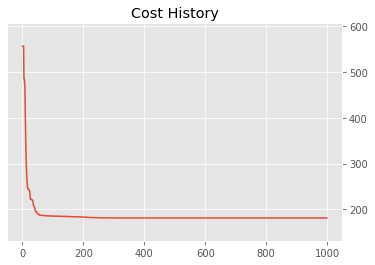

In [22]:
plot_history(history)

In [23]:
print(f'MSE on validation set: {mean_squared_error(predict(X_test, pos),y_test)}')

MSE on validation set: 271.66310372463937


## Overfit Model

In [24]:
%%time
np.random.set_state(checkpoint_state)
options = {'c1': 0.1, 'c2': 0.9, 'w':0.9} #best_cost=167, mse: 542.73 (overfit)
cost, pos, history = train_model(options)

2019-11-17 07:14:12,160 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.9, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=167
2019-11-17 07:14:48,030 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 166.74146441803478, best pos: [ 1.41496042e+00 -2.22816088e+00 -2.34302221e+00  2.43964116e-01
  1.06563529e+00  1.92453238e+00  3.55506502e+00 -1.95323453e-02
  2.72965118e+00 -4.13669305e+00  7.12966409e-01  7.61197633e-01
 -3.89892464e+00 -7.66748469e-01 -2.17355198e+00 -6.17261686e+00
  2.04315119e+00  1.43090951e+01 -2.60211402e+00 -8.26342191e+00
  4.95058298e-01 -9.64171102e-01 -8.05983555e-01  3.63527102e+00
 -5.03072365e+00 -3.78918480e+00 -1.47292630e+01 -3.11477483e+00
 -3.22835755e+00 -3.76231530e+00  3.31571009e+00 -9.76703121e-01
 -3.09067442e+00 -5.91820771e+00 -3.73814794e+00  4.63178862e+00
  2.29318733e+00 -3.89512283e+00  3.33758672e-01 -4.12826945e-01
 -2.14003405e+00  5.5025844


Model Run times:
CPU times: user 35.2 s, sys: 581 ms, total: 35.8 s
Wall time: 35.9 s


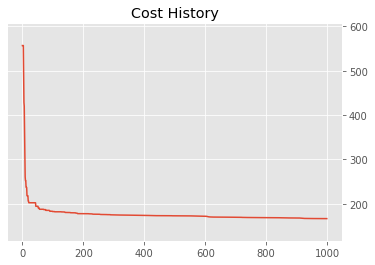

In [25]:
plot_history(history)

In [26]:
print(f'MSE on validation set: {mean_squared_error(predict(X_test, pos),y_test)}')

MSE on validation set: 542.7309392335013


## Final Model

In [27]:
%%time
np.random.set_state(checkpoint_state)
options = {'c1': 0.5, 'c2': 0.9, 'w':0.9} #best_cost=170, mse 229.73
cost, pos, history = train_model(options)

2019-11-17 07:14:48,286 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=170
2019-11-17 07:15:25,056 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 169.61206225995664, best pos: [  2.00768663   3.34508142   0.19703955  -3.77570725   2.0843282
   4.5593267    2.18594182  -1.99762304   0.62651478  -1.96151844
   1.18450344   1.5020179    1.01973577 -11.35452127   1.15328029
   2.55823911   2.12268206   3.70573384   2.50607085  -2.61810646
   1.8364344    6.06580427  -0.59448513  -0.37584315  -0.97954863
   0.83457327  -2.74755476   0.70264744  -4.11668757  -0.83989182
   0.96989495   1.00009665  -3.54075167  -0.538787    -2.35230938
   0.78082879   1.27657758  -2.28180065  -0.78572972   3.35502109
   2.8683374    0.31318902   0.34908631   0.47968633   0.86542455
  -3.21365745   2.04742916  -0.65130135  -0.07516506  -0.80106557
   0.2759012    1.


Model Run times:
CPU times: user 36.4 s, sys: 621 ms, total: 37 s
Wall time: 36.8 s


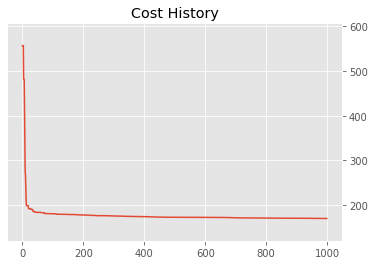

In [28]:
plot_history(history)

In [29]:
print(f'MSE on validation set: {mean_squared_error(predict(X_test, pos),y_test)}')

MSE on validation set: 229.73113330078823


# Workout Optimization with Differential Evolution

In [0]:
daily_target = -9 # daily loss aim in ounces, approx 0.25kg
confidence_factor = 0.5 # parameter to tuned in system

In [0]:
def de_predict(X):
    z = X
    for i in range(1,len(X)):
        z[i] = np.round(z[i])
    z = scaler.transform(np.array([z]))
    return np.abs(predict(z,pos) - daily_target/confidence_factor)

In [0]:
def recommend_exercise(calorie):
    bounds = [(calorie,calorie+1)] + len(exercises)*[(0,1)]
    result = differential_evolution(de_predict, bounds=bounds)
    return [exercise for recommend, exercise in zip(result.x[1:], exercises) if recommend]

## Scenario - Sample Menu Recommendation

In [33]:
assigned = pd.read_csv('sample_menu.csv')
assigned['recommended_exercise'] = assigned['calories'].apply(lambda x: 
                                                           ' | '.join(recommend_exercise(x)))
assigned

,recommended_food,calories,recommended_exercise
0,Ipoh Horfun | Ee Mee Seafood (Fried) | Butter ...,2135,walk
1,Braised Duck With Yam Rice | Lor Mee | Chicken...,1579,
2,Pork Satay with Sauce (10 sticks) | Fried Hokk...,1877,
3,Laksa | Tau Suan | Pork Porridge,1257,
4,Ngoh Hiang Mixed Items | Alfredo Pasta | Roti ...,1951,walk
5,Carbonara | Roti Prata Plain (2 pieces) | Mac ...,1580,
6,Mee Rebus | Nasi Lemak | Fish and Chips,2075,walk


## Scenario - Festive Season Simulation

In [34]:
festive = assigned.copy().drop(columns=['recommended_food'])
festive.rename(columns={'calories': 'old_calories', 
                        'recommended_exercise': 'old_recommended_exercise'}, 
               inplace=True)

festive['new_calories'] = festive['old_calories'].copy()
festive.at[1,'new_calories'] = 2500
festive.at[2,'new_calories'] = 2700
festive.at[4,'new_calories'] = 2900

festive['new_recommended_exercise'] = festive['new_calories']\
                                        .apply(lambda x: 
                                               ' | '.join(recommend_exercise(x)))

festive

,old_calories,old_recommended_exercise,new_calories,new_recommended_exercise
0,2135,walk,2135,walk
1,1579,,2500,walk | run
2,1877,,2700,run
3,1257,,1257,
4,1951,walk,2900,run
5,1580,,1580,
6,2075,walk,2075,walk


# Simulation - New Exercise Added

In [0]:
raw_new = pd.read_csv(basepath/'diet_data_new_simulated.csv')

In [36]:
raw_new.tail()

,Date,Stone,Pounds,Ounces,weight_oz,calories,cals_per_oz,five_donuts,walk,run,wine,swim,prot,weight,change
158,1/4/2019,-9999.0,-9999.0,-9999.0,2530.0,2750.0,-9999.0,-9999.0,0.0,0.0,-9999.0,0,-9999.0,-9999.0,-3.0
159,1/5/2019,-9999.0,-9999.0,-9999.0,2527.0,2950.0,-9999.0,-9999.0,1.0,1.0,-9999.0,0,-9999.0,-9999.0,-19.0
160,1/6/2019,-9999.0,-9999.0,-9999.0,2508.0,1950.0,-9999.0,-9999.0,1.0,1.0,-9999.0,1,-9999.0,-9999.0,-25.0
161,1/7/2019,-9999.0,-9999.0,-9999.0,2483.0,1900.0,-9999.0,-9999.0,1.0,0.0,-9999.0,1,-9999.0,-9999.0,-21.0
162,1/8/2019,-9999.0,-9999.0,-9999.0,2462.0,1500.0,-9999.0,-9999.0,1.0,0.0,-9999.0,0,-9999.0,-9999.0,-10.0


In [0]:
X_train, X_test, y_train, y_test, exercises, scaler = preprocess_data(raw_new)

In [38]:
print(f'Updated exercises: {", ".join(exercises)}')

Updated exercises: walk, run, swim


## Retrain Model

In [0]:
# Neural network architecture
n_inputs = 1+len(exercises)
n_hidden = 20
n_classes = 1

i_weights, i_bias, h_weights, h_bias, n_params = calc_nn_params(n_inputs, n_hidden, n_classes)

In [40]:
%%time
np.random.set_state(checkpoint_state)
options = {'c1': 0.5, 'c2': 0.5, 'w':0.9}
cost, pos, history = train_model(options)

2019-11-17 07:15:26,674 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=175
2019-11-17 07:16:02,849 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 175.01123450907198, best pos: [-2.04028661e-01 -3.54787909e+00  8.58259776e-01 -1.79503028e+00
  2.96279967e-01 -5.77611641e-01 -8.50132091e-01  6.15314930e-03
  1.93975612e-01 -1.45163509e+00 -8.00815388e-01  2.62035806e+00
 -1.51902296e-01 -4.47507030e-01 -3.00211682e+00 -4.25584591e-01
 -5.92668094e-01 -5.96044994e+00  8.77048752e-01 -5.84667271e-02
  2.63077399e-02 -1.32384218e+00  9.77748564e-01 -2.15853201e+00
  4.75474363e-01  1.01894233e+00 -5.42261772e+00 -2.59792412e-01
 -5.83710635e-01  5.84044213e-01 -5.75483043e-01 -2.34497197e+00
 -1.00996128e+00 -8.11735412e-01 -1.01447682e+00 -2.39812653e+00
 -2.17866038e+00 -3.81043246e-01  2.31704213e+00 -9.82010955e-01
 -7.75943700e-01  2.7158935


Model Run times:
CPU times: user 35.5 s, sys: 594 ms, total: 36.1 s
Wall time: 36.2 s


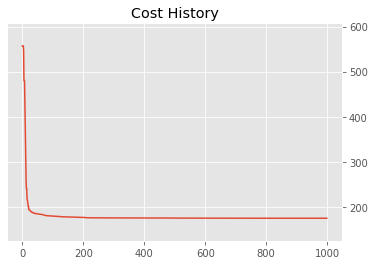

In [41]:
plot_history(history)

In [42]:
print(f'MSE on validation set: {mean_squared_error(predict(X_test, pos),y_test)}')

MSE on validation set: 319.05547166307105


## Scenario Reun - Sample Menu Recommendation

In [43]:
assigned = pd.read_csv('sample_menu.csv')
assigned['recommended_exercise'] = assigned['calories'].apply(lambda x: 
                                                           ' | '.join(recommend_exercise(x)))
assigned

,recommended_food,calories,recommended_exercise
0,Ipoh Horfun | Ee Mee Seafood (Fried) | Butter ...,2135,walk
1,Braised Duck With Yam Rice | Lor Mee | Chicken...,1579,
2,Pork Satay with Sauce (10 sticks) | Fried Hokk...,1877,swim
3,Laksa | Tau Suan | Pork Porridge,1257,
4,Ngoh Hiang Mixed Items | Alfredo Pasta | Roti ...,1951,walk | swim
5,Carbonara | Roti Prata Plain (2 pieces) | Mac ...,1580,
6,Mee Rebus | Nasi Lemak | Fish and Chips,2075,walk


## Scenario Reun - Festive Season Simulation

In [44]:
festive = assigned.copy().drop(columns=['recommended_food'])
festive.rename(columns={'calories': 'old_calories', 
                        'recommended_exercise': 'old_recommended_exercise'}, 
               inplace=True)

festive['new_calories'] = festive['old_calories'].copy()
festive.at[1,'new_calories'] = 2500
festive.at[2,'new_calories'] = 2700
festive.at[4,'new_calories'] = 2900

festive['new_recommended_exercise'] = festive['new_calories']\
                                        .apply(lambda x: 
                                               ' | '.join(recommend_exercise(x)))

festive

,old_calories,old_recommended_exercise,new_calories,new_recommended_exercise
0,2135,walk,2135,walk
1,1579,,2500,run
2,1877,swim,2700,run | swim
3,1257,,1257,
4,1951,walk | swim,2900,run | swim
5,1580,,1580,
6,2075,walk,2075,walk
